In [1]:
import torch
import Tournament
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from importlib import reload
reload(Tournament)
sce = Tournament.symmetric_cross_entropy
Tournament = Tournament.Tournament
nn = torch.nn
F = nn.functional

In [34]:
class CNNModel(torch.nn.Module):
    def __init__(self, device = 'cpu'):
        super(CNNModel, self).__init__()
        self.device = device
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        return x
class MLPModel(torch.nn.Module):
    def __init__(self, device = 'cpu'):
        super(MLPModel, self).__init__()
        self.device = device
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*32*3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return x

class BaseModel(torch.nn.Module):
    def __init__(self, model, device = 'cpu'):
        super(BaseModel, self).__init__()
        self.device = device
        self.model = model
        self.fc2 = nn.Linear(128, 10)
        self.batchnorm = nn.BatchNorm1d(10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, train = False):
        x = self.model(x)
        x = self.fc2(x)
        x = self.batchnorm(x)
        x = self.sigmoid(x)
        if train:
            x = F.softmax(x, dim=1)
        return x

class TournamentModel(torch.nn.Module):
    def __init__(self, model, device = 'cpu'):
        super(TournamentModel, self).__init__()
        self.device = device
        self.model = model
        self.tournament = Tournament(num_classes=10)
        self.fc2 = nn.Linear(128, self.tournament.num_edges)
        self.batchnorm = nn.BatchNorm1d(self.tournament.num_edges)
        # self.batchnorm = nn.Identity(self.tournament.num_edges)
        self.sigmoid = nn.Sigmoid()
        self.layers = [self.model, self.fc2, self.batchnorm, self.sigmoid]
        self.middle = nn.Sequential(*self.layers)
    def forward(self, x, train = False):
        x = self.middle(x)
        x = self.tournament(x)
        # if train:
            # x = F.softmax(x, dim=1)
        return x


In [45]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), F.one_hot(target.to(device), num_classes=10).float()
        optimizer.zero_grad()
        output = model(data, train=True)
        # print(output.min(), output.max())
        loss = sce(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})
def test_basic(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target_oh = F.one_hot(target, num_classes=10).float()
            output_sm = model(data, train=True)
            output = model(data)
            test_loss += sce(output_sm, target_oh, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return test_loss, accuracy

def clip(data, threshold = .6):
    data = data - threshold
    data = torch.clamp(data, 0, (1-threshold))
    data = data * (1/(1-threshold))
    return data
clip_test = torch.linspace(0,1,25)
print(clip(clip_test))


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0625, 0.1667, 0.2708,
        0.3750, 0.4792, 0.5833, 0.6875, 0.7917, 0.8958, 1.0000])


In [36]:
train_dataset = datasets.CIFAR10('../data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ]))
test_dataset = datasets.CIFAR10('../data', train=False,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ]))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = CNNModel
# backbone = MLPModel
base_model = BaseModel(model = backbone(), device = device)
tournament_model = TournamentModel(model = backbone(), device = device)
optimizer_base = torch.optim.Adam(base_model.parameters(), lr=0.001)
optimizer_tournament = torch.optim.Adam(tournament_model.parameters(), lr=0.001)
num_epochs = 10

In [52]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch}: Base Model")
    train(base_model, device, train_loader, optimizer_base, epoch)
    test_basic(base_model, device, test_loader)

Epoch 0: Base Model


100%|██████████| 782/782 [00:58<00:00, 13.47it/s, loss=0.281]



Test set: Average loss: 2.7633, Accuracy: 6463/10000 (64.63%)

Epoch 1: Base Model


100%|██████████| 782/782 [00:58<00:00, 13.42it/s, loss=0.271]



Test set: Average loss: 2.6368, Accuracy: 7166/10000 (71.66%)

Epoch 2: Base Model


100%|██████████| 782/782 [00:58<00:00, 13.36it/s, loss=0.269]



Test set: Average loss: 2.5885, Accuracy: 7404/10000 (74.04%)

Epoch 3: Base Model


100%|██████████| 782/782 [00:59<00:00, 13.22it/s, loss=0.277]



Test set: Average loss: 2.5708, Accuracy: 7224/10000 (72.24%)

Epoch 4: Base Model


100%|██████████| 782/782 [00:57<00:00, 13.71it/s, loss=0.248]



Test set: Average loss: 2.5427, Accuracy: 7573/10000 (75.73%)

Epoch 5: Base Model


100%|██████████| 782/782 [00:59<00:00, 13.10it/s, loss=0.248]



Test set: Average loss: 2.5181, Accuracy: 7640/10000 (76.40%)

Epoch 6: Base Model


100%|██████████| 782/782 [01:02<00:00, 12.48it/s, loss=0.25] 



Test set: Average loss: 2.5235, Accuracy: 7590/10000 (75.90%)

Epoch 7: Base Model


100%|██████████| 782/782 [00:59<00:00, 13.24it/s, loss=0.248]



Test set: Average loss: 2.5169, Accuracy: 7648/10000 (76.48%)

Epoch 8: Base Model


100%|██████████| 782/782 [00:58<00:00, 13.29it/s, loss=0.232]



Test set: Average loss: 2.5151, Accuracy: 7674/10000 (76.74%)

Epoch 9: Base Model


100%|██████████| 782/782 [00:57<00:00, 13.64it/s, loss=0.244]



Test set: Average loss: 2.5079, Accuracy: 7721/10000 (77.21%)



In [53]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch}: Tournament Model")
    train(tournament_model, device, train_loader, optimizer_tournament, epoch)
    test_basic(tournament_model, device, test_loader)

Epoch 0: Tournament Model


100%|██████████| 782/782 [00:57<00:00, 13.67it/s, loss=0.866]



Test set: Average loss: 8.6989, Accuracy: 6333/10000 (63.33%)

Epoch 1: Tournament Model


100%|██████████| 782/782 [00:58<00:00, 13.43it/s, loss=0.822]



Test set: Average loss: 8.4937, Accuracy: 7166/10000 (71.66%)

Epoch 2: Tournament Model


100%|██████████| 782/782 [00:59<00:00, 13.11it/s, loss=0.838]



Test set: Average loss: 8.3878, Accuracy: 7466/10000 (74.66%)

Epoch 3: Tournament Model


100%|██████████| 782/782 [00:59<00:00, 13.21it/s, loss=0.84] 



Test set: Average loss: 8.3444, Accuracy: 7529/10000 (75.29%)

Epoch 4: Tournament Model


100%|██████████| 782/782 [00:59<00:00, 13.21it/s, loss=0.8]  



Test set: Average loss: 8.3011, Accuracy: 7682/10000 (76.82%)

Epoch 5: Tournament Model


100%|██████████| 782/782 [01:01<00:00, 12.71it/s, loss=0.791]



Test set: Average loss: 8.2793, Accuracy: 7689/10000 (76.89%)

Epoch 6: Tournament Model


100%|██████████| 782/782 [00:58<00:00, 13.29it/s, loss=0.784]



Test set: Average loss: 8.2852, Accuracy: 7668/10000 (76.68%)

Epoch 7: Tournament Model


100%|██████████| 782/782 [00:58<00:00, 13.30it/s, loss=0.786]



Test set: Average loss: 8.2873, Accuracy: 7707/10000 (77.07%)

Epoch 8: Tournament Model


100%|██████████| 782/782 [00:58<00:00, 13.29it/s, loss=0.797]



Test set: Average loss: 8.3010, Accuracy: 7647/10000 (76.47%)

Epoch 9: Tournament Model


100%|██████████| 782/782 [00:58<00:00, 13.29it/s, loss=0.794]



Test set: Average loss: 8.3192, Accuracy: 7690/10000 (76.90%)



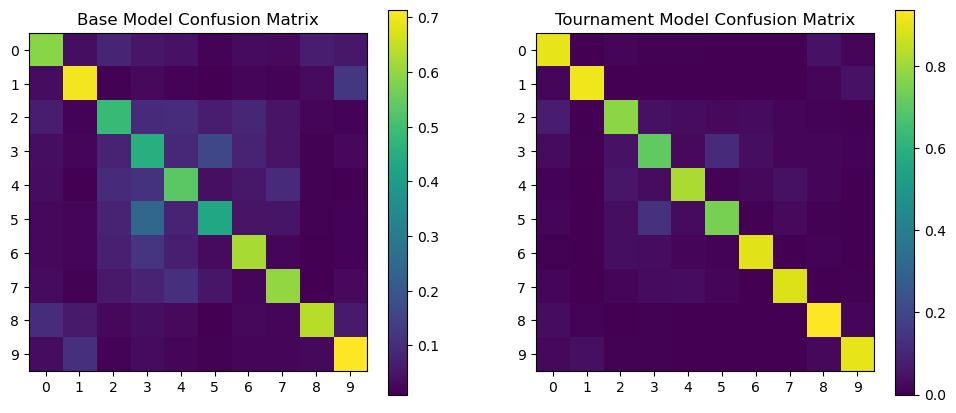

In [70]:
confidences_base = torch.zeros((10,10))
confidences_tournament = torch.zeros((10,10))
threshold = .8
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output_base = base_model(data,train=False)
        # output_base = clip(output_base, threshold = threshold)
        output_tournament = tournament_model(data,train=False)
        output_tournament = clip(output_tournament, threshold = threshold)
        for i in range(10):
            mask = (target == i)
            if mask.sum() > 0:
                confidences_base[i] += output_base[mask].sum(0).cpu()
                confidences_tournament[i] += output_tournament[mask].sum(0).cpu()
confidences_base /= confidences_base.sum(1, keepdim=True)
confidences_tournament /= confidences_tournament.sum(1, keepdim=True)
# vmin = min(confidences_base.log().min(), confidences_tournament.log().min())
vmin, vmin_t = confidences_base.min(), confidences_tournament.min()
# vmax = max(confidences_base.log().max(), confidences_tournament.log().max())
vmax, vmax_t = confidences_base.max(), confidences_tournament.max()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.title('Base Model Confusion Matrix')
plt.imshow(confidences_base, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(1,2,2)
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.title('Tournament Model Confusion Matrix')
plt.imshow(confidences_tournament, vmin=vmin_t, vmax=vmax_t)
plt.colorbar()
plt.show()

tensor(0.0043) tensor(0.2498)


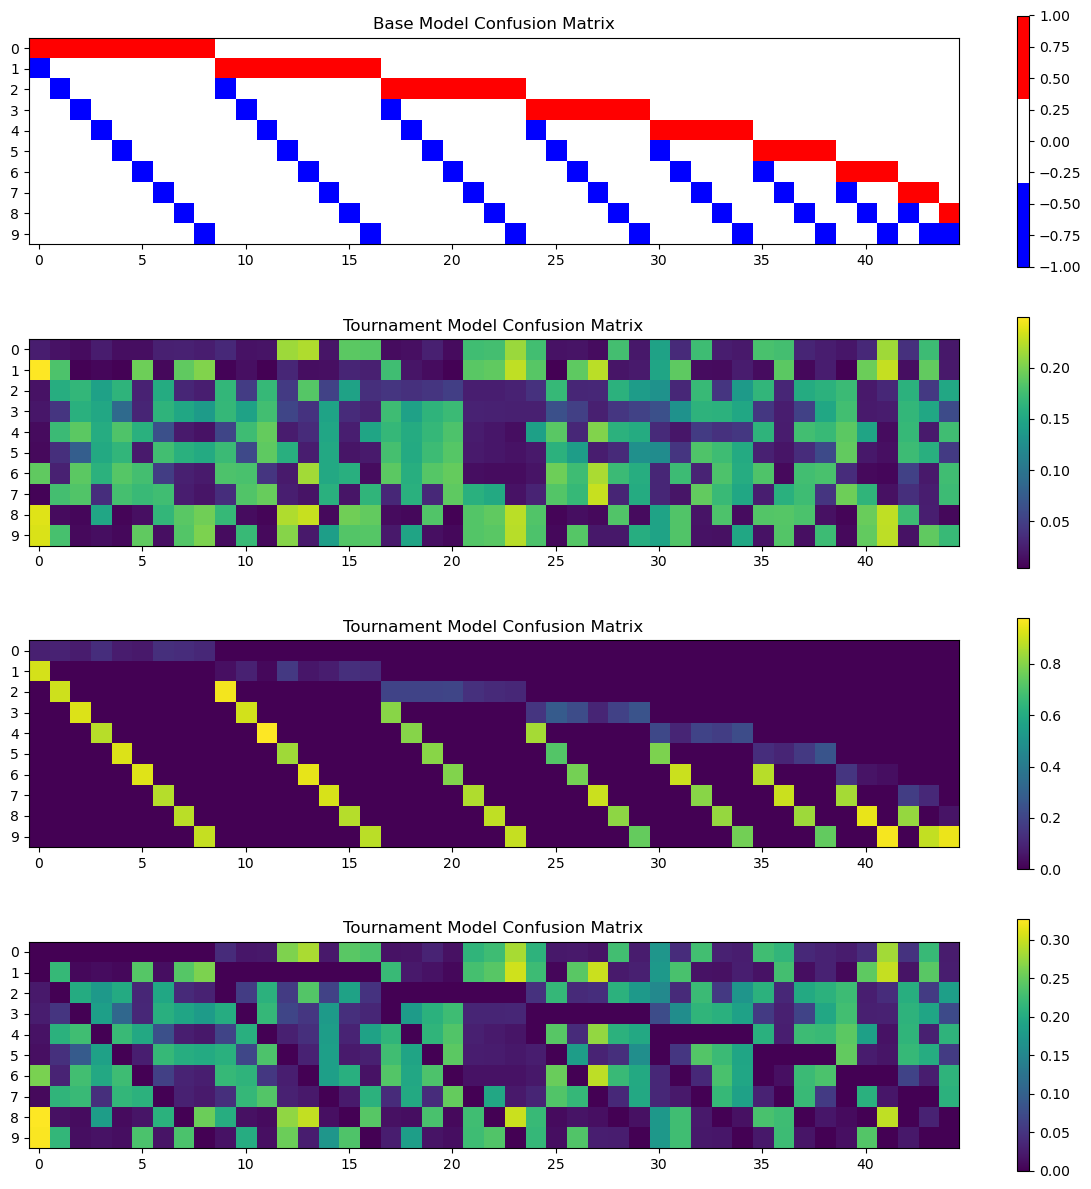

In [88]:
def ternary(x):
    x = x.clone()
    # x[x < .4] = 1
    # x[(x >= .4) & (x < .6)] = 0.0
    # x[x >= .6] = -1
    return x
confidences_base = torch.zeros((10,10))
confidences_tournament = torch.zeros((10,tournament_model.tournament.num_edges))
perfect_tournament = tournament_model.tournament.gt.clone()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output_base = base_model(data,train=False)
        output_tournament = tournament_model.middle(data)
        # output_tournament = ternary(output_tournament)
        for i in range(10):
            mask = (target == i)
            if mask.sum() > 0:
                confidences_base[i] += output_base[mask].sum(0).cpu()
                confidences_tournament[i] += output_tournament[mask].sum(0).cpu()
# confidences_base /= confidences_base.sum(1, keepdim=True)
confidences_tournament /= confidences_tournament.sum(0, keepdim=True)
vmin = confidences_tournament.min()
vmax = confidences_tournament.max()
print(vmin,vmax)
# I need a trinary color map for the perfect tournament
cmap = plt.get_cmap('bwr', 3)
plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
# plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.title('Base Model Confusion Matrix')
# plt.imshow(perfect_tournament, vmin=vmin, vmax=vmax, cmap=cmap)
plt.imshow(perfect_tournament, cmap=cmap)
plt.colorbar()
plt.subplot(4,1,2)
# plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.title('Tournament Model Confusion Matrix')
plt.imshow(confidences_tournament, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.subplot(4,1,3)
# plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.title('Tournament Model Confusion Matrix')
masked = confidences_tournament * perfect_tournament.abs()
masked /= masked.sum(0, keepdim=True)
plt.imshow(masked, vmin=masked.min(), vmax=masked.max())
plt.colorbar()
plt.subplot(4,1,4)
# plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.title('Tournament Model Confusion Matrix')
masked = confidences_tournament * (1-perfect_tournament.abs())
masked /= masked.sum(0, keepdim=True)
plt.imshow(masked, vmin=masked.min(), vmax=masked.max())
plt.colorbar()
plt.show()

/var/folders/6d/1k2xm78s2c17nwkp_3wr7sbm0000gq/T/ipykernel_86692/3436643564.py:11: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::bincount. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1752197847897/work/aten/src/ATen/functorch/BatchedFallback.cpp:84.)
  counts = torch.bincount(selected_values, minlength=K)


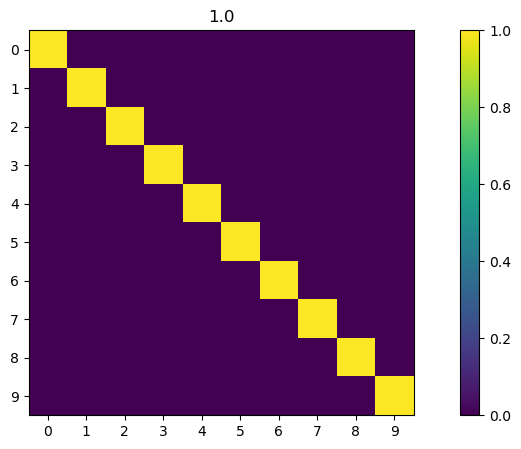

In [112]:
# def get_gt_stuff(num_classes):
#     ground_truth_indicies, ground_truth_values = [],[]
#     for k in range(num_classes):
#         i,v = torch.where(tournament_model.tournament.perms == k)
#         ground_truth_indicies.append(i)
#         ground_truth_values.append(v)
#     return torch.stack(ground_truth_values).T, torch.stack(ground_truth_indicies).T
def select_by_binary_indices(data_array, K):
    def func(binary_array):
        selected_values = data_array[torch.arange(binary_array.shape[0]), binary_array].to(torch.int64)
        counts = torch.bincount(selected_values, minlength=K)
        # m = torch.max(counts)
        # mask = counts == m
        # c = mask.sum()
        # condition = (c == 1).to(torch.int32)
        # out = condition * (counts.argmax()+1) - 1
        return counts
    return torch.func.vmap(func)
# ground_truth_val, ground_truth_ind = get_gt_stuff(10)
def assign(x):
    x = x.clone()
    x[x <= .5] = 0
    x[x > .5] = 1
    out = select_by_binary_indices(tournament_model.tournament.perms, 10)(x.to(torch.int64))
    return out
confidences_tournament = torch.zeros((10,10))
threshold = .8
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # output_base = clip(output_base, threshold = threshold)
        output_tournament = tournament_model.middle(data)
        output_tournament = assign(output_tournament)
        for i in range(10):
            mask = (target == i)
            if mask.sum() > 0:
                confidences_tournament[i] += output_tournament[mask].sum(0).cpu()
confidences_base /= confidences_base.sum(1, keepdim=True)
confidences_tournament = confidences_tournament.softmax(1)
confidences_tournament /= confidences_tournament.sum(0, keepdim=True)
# vmin = min(confidences_base.log().min(), confidences_tournament.log().min())
vmin, vmin_t = confidences_base.min(), confidences_tournament.min()
# vmax = max(confidences_base.log().max(), confidences_tournament.log().max())
vmax, vmax_t = confidences_base.max(), confidences_tournament.max()
plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.xticks(list(range(10)))
# plt.yticks(list(range(10)))
# plt.title('Base Model Confusion Matrix')
# plt.imshow(confidences_base, vmin=vmin, vmax=vmax)
# plt.colorbar()
plt.subplot(1,1,1)
plt.xticks(list(range(10)))
plt.yticks(list(range(10)))
plt.title(f'{confidences_tournament.trace()/confidences_tournament.sum()}')
plt.imshow(confidences_tournament, vmin=vmin_t, vmax=vmax_t)
plt.colorbar()
plt.show()